**Навигация по уроку**

1. [Введение в сверточные нейронные сети](https://colab.research.google.com/drive/10cBnEfHhZlv3ZhEgVimA3GqSEZtvqpTv)
2. [Обучение сверточной нейронной сети на ограниченном наборе данных](https://colab.research.google.com/drive/1e1aZ9K1vQIujPf1mzmta5xtbfNqJ_ai-)
3. [Предобученные сверточные НС](https://colab.research.google.com/drive/12VehrJe062P9QImtvjILQG0DOLooiyk0)
4. Домашняя работа

В данном домашнем задании вам необходимо:

1. Используйте датасет "Собаки и кошки", рассмотренный в данном уроке. Причем используйте его целиком, а не только 4000 изображений.
2. Проведите аугментацию изображений.
3. В качестве предобученной модели возьмите `MobileNet`
4. Создайте модель, приведенную ниже.
5. Обучите модель и проверьте на тестовой выборке.
6. Если модель не обеспечивает заданную точность - "поиграйтесь" с гиперпараметрами.


Для получения 3 баллов за задание необходимо достичь на контрольной выборке точности 90%, 4 баллов -  более 93%, 5 баллов - более 95%.

На 20 тыс. изображений данная модель выдавала нам результат 99%.

**Подсказка**. Обратите внимание, что предлагаемая модель уже не является бинарной классификацией. Это уже задача многоклассовой классификации (в нашем случае 2 класса). А значит в генераторах изображений необходимо использовать:

```pyton
class_mode='categorical'
```

Также необходимо вспомнить какую функцию ошибки использовать с задачей многоклассовой классификации. Можно попробовать в качестве оптимизатора использовать Adam с разными шагами.

Также обратите внимание, что вместо слоя `Flatten()`, вам предлагается использовать `GlobalAveragePooling2D()` (https://keras.io/api/layers/pooling_layers/global_average_pooling2d/).


In [1]:
# Ваше решение

#Загрузка данных

In [2]:
#скачиваем
!wget https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
!unzip -qo "cat-and-dog" -d ./temp

--2025-03-27 05:48:22--  https://storage.yandexcloud.net/academy.ai/cat-and-dog.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228082266 (218M) [application/x-zip-compressed]
Saving to: ‘cat-and-dog.zip’

cat-and-dog.zip     100%[===================>] 217.52M  24.2MB/s    in 11s     

2025-03-27 05:48:34 (20.7 MB/s) - ‘cat-and-dog.zip’ saved [228082266/228082266]



In [3]:
import os
import shutil

#папка с картинками категорий
IMAGE_PATH_TRAIN = './temp/training_set/training_set/'
IMAGE_PATH_TEST = './temp/test_set/test_set/'
#выборки сета
BASE_DIR = './dataset/'
#список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH_TRAIN))
#количество классов
CLASS_COUNT = len(CLASS_LIST)

#при перезапуске чистим каталог и создаем заново
if os.path.exists(BASE_DIR):
    shutil.rmtree(BASE_DIR)

#создаем папку
os.mkdir(BASE_DIR)

#создаем в BASE_DIR подпапку с указанным именем
def make_dir(dir, BASE_DIR=BASE_DIR):
    new_dir = os.path.join(BASE_DIR, dir)
    os.mkdir(new_dir)
    return new_dir

#создаем папки по добавленным именам
train_dir = make_dir('train')
validation_dir = make_dir('validation')
test_dir = make_dir('test')

#Разделение данных на выборки
В уроке не использовалась папка test_set, в которой по 1000 изображений каждого класса. Использую ее для контрольной выборки.

- Так же при быстром осмотре нашел фото собаки в тестовой выборке './temp/test_set/test_set/' кошек: **cat.4085.jpg**, и кошки в тестовой выборке './temp/test_set/test_set/' собак: **dog.4334.jpg**, нужно будет их перенести. Так же обнаружился обычный баннер, не относящийся к классификации в тестовой выборке './temp/test_set/test_set/' собак: **dog.4367.jpg**.

- Так же возник интересный вопрос - в папке с обучением './temp/training_set/training_set/' на кошках есть фото **cat.3822.jpg**, на котором присутствуют оба класса - как в таком случае среагирует модель при обучении и при контрольной проверке. И если при контрольной проверке можно прогнать конкретное фото и посмотреть результат, хоть модель и выдаст по софтмакс больший шанс принадлежности к классу, то возникает вопрос о мультиклассовом присутствии. Скорее всего это будет далее в курсе (как вариант - мультиклассовые НС). Но останется не понятно поведение текущей модели при обучении на таком фото, так как все параметры НС не получится интерпретировать в человеческом понимании. В данном случае так же удалю фото из сета для чистоты обучения.

In [4]:
# удаляем лишние фото и переносим нужные
file_to_del = IMAGE_PATH_TEST + 'dogs/dog.4367.jpg'
if os.path.exists(file_to_del):
    os.remove(file_to_del)
    print(f'Файл {file_to_del} удален')
else:
    print(f'Файл {file_to_del} не найден')

file_to_del = IMAGE_PATH_TRAIN + 'cats/cat.3822.jpg'
if os.path.exists(file_to_del):
    os.remove(file_to_del)
    print(f'Файл {file_to_del} удален')
else:
    print(f'Файл {file_to_del} не найден')

file_to_move = IMAGE_PATH_TEST + 'cats/cat.4085.jpg'
dst_dir = IMAGE_PATH_TEST + 'dogs/cat.4085.jpg'
if os.path.exists(file_to_move):
    shutil.move(file_to_move, dst_dir)
    print(f'Файл {file_to_move} перемещен')
else:
    print(f'Файл {file_to_move} не найден')

file_to_move = IMAGE_PATH_TEST + 'dogs/dog.4334.jpg'
dst_dir = IMAGE_PATH_TEST + 'cats/dog.4334.jpg'
if os.path.exists(file_to_move):
    shutil.move(file_to_move, dst_dir)
    print(f'Файл {file_to_move} перемещен')
else:
    print(f'Файл {file_to_move} не найден')


Файл ./temp/test_set/test_set/dogs/dog.4367.jpg удален
Файл ./temp/training_set/training_set/cats/cat.3822.jpg удален
Файл ./temp/test_set/test_set/cats/cat.4085.jpg перемещен
Файл ./temp/test_set/test_set/dogs/dog.4334.jpg перемещен


In [5]:
def create_dataset(
        img_path: str,      # путь к файлам классов
        new_path: str,      # путь к папке для выборки
        class_name: str,    # имя класса (такое же что и имя папки)
        start_index: int,   # начальный процент выборки
        end_index: int      # конечный процент выборки
):

    src_path = os.path.join(img_path, class_name)   # полный путь к папке с классом
    dst_path = os.path.join(new_path, class_name)   # путь к выборке датасета

    # получаем список имен файлов класса
    class_files = os.listdir(src_path)
    # смотрим длинну выборки
    n = len(class_files)
    #создаем подпапку класса для выборки
    os.mkdir(dst_path)

    # перебираем файлы класса и копируем их в подпапку этого класса в выборке
    for fname in class_files[int(start_index/100 * n) : int(end_index/100 * n)]:
        # путь к файлу источнику
        src = os.path.join(src_path, fname)
        # новый путь к файлу
        dst = os.path.join(dst_path, fname)
        # копируем
        shutil.copyfile(src, dst)

for class_label in range(CLASS_COUNT):      # перебор по классам по порядку номеров
    class_name = CLASS_LIST[class_label]    # присваиваем имя класса для использования в цикле

    #создаем обучающую выборку 80% от обучающего датасета
    create_dataset(IMAGE_PATH_TRAIN, train_dir, class_name, 0, 80)
    #создаем проверочную выборку 20% от обучающего датасета
    create_dataset(IMAGE_PATH_TRAIN, validation_dir, class_name, 80, 100)
    #создаем тестовую выборку 100% от тестового датасета
    create_dataset(IMAGE_PATH_TEST, test_dir, class_name, 0, 100)

In [6]:
print(f"выборка обучения на собаках {len(os.listdir(BASE_DIR + 'train/dogs'))}")
print(f"выборка валидации на собаках {len(os.listdir(BASE_DIR + 'validation/dogs'))}")
print(f"выборка теста на собаках {len(os.listdir(BASE_DIR + 'test/dogs'))}")

выборка обучения на собаках 3204
выборка валидации на собаках 801
выборка теста на собаках 1011


In [7]:
print(f"выборка обучения на кошках {len(os.listdir(BASE_DIR + 'train/cats'))}")
print(f"выборка валидации на кошках {len(os.listdir(BASE_DIR + 'validation/cats'))}")
print(f"выборка теста на кошках {len(os.listdir(BASE_DIR + 'test/cats'))}")

выборка обучения на кошках 3199
выборка валидации на кошках 800
выборка теста на кошках 1011


#Создаем генераторы данных

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_WIDTH, IMG_HEIGHT = (150, 150)

# генератор обучающей выборки
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# генератор тестовой выборки
test_datagen = ImageDataGenerator(rescale=1./255)

# генерация картинок обучения
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=20,
    class_mode='categorical'
)

# генерация картинок валидации
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=20,
    class_mode='categorical'
)

print(train_generator.class_indices)

Found 6403 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
{'cats': 0, 'dogs': 1}


#Строим модель НС

In [9]:
from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras import optimizers

NUM_CLASSES = train_generator.num_classes

def model_maker():
    base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

    for layer in base_model.layers[:]:
        layer.trainable = False

    input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    custom_model = base_model(input)
    custom_model = GlobalAveragePooling2D()(custom_model)
    custom_model = Dense(64, activation='relu')(custom_model)
    custom_model = Dropout(0.5)(custom_model)
    predictions = Dense(NUM_CLASSES, activation='softmax')(custom_model)

    return Model(inputs=input, outputs=predictions)

In [10]:
model = model_maker()
model.summary()

<ipython-input-9-8093e0af6b21>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenet_1.00_224 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,294,594 (12.57 MB)

 Trainable params: 65,730 (256.76 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

MobileNet имеет 3 млн параметров в себе, однако обучать мы их уже не будем, т.к. потеряется весь смысл предобучения. Обучаемых параметров в нашей версии модели всего 65 тыс. на плотных слоях.

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5),
              metrics=['acc']
              )

#Обучаем модель и смотрим результаты

In [13]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - acc: 0.4926 - loss: 1.7204 - val_acc: 0.7420 - val_loss: 0.5558
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 48s 148ms/step - acc: 0.6689 - loss: 0.8594 - val_acc: 0.8676 - val_loss: 0.3161
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 44s 136ms/step - acc: 0.7475 - loss: 0.5853 - val_acc: 0.9076 - val_loss: 0.2334
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - acc: 0.7965 - loss: 0.4744 - val_acc: 0.9257 - val_loss: 0.1958
Epoch 5/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - acc: 0.8264 - loss: 0.4107 - val_acc: 0.9338 - val_loss: 0.1743
Epoch 6/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - acc: 0.8398 - loss: 0.3671 - val_acc: 0.9425 - val_loss: 0.1592
Epoch 7/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 133ms/step - acc: 0.8481 - loss: 0.3485 - val_acc: 0.9444 - val_loss: 0.1466
Epoch 8/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 43s 135ms/step - acc: 0.8651 - loss: 0.3235 - val_acc: 0.9513 - val_loss: 0.1374
Epoch 9/30
321/321 ━━━━━━━━━━━━━

In [14]:
import matplotlib.pyplot as plt

# Рисуем графики
def show_history(store):
    acc = store.history['acc']
    val_acc = store.history['val_acc']
    loss = store.history['loss']
    val_loss = store.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, '--', label='Точность на проверочной выборке')
    plt.title('График точности на проверочной и обучающей выборках')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, '--', label='Потери на проверочной выборке')
    plt.title('График потерь на проверочной и обучающей выборках')
    plt.legend()
    plt.show()

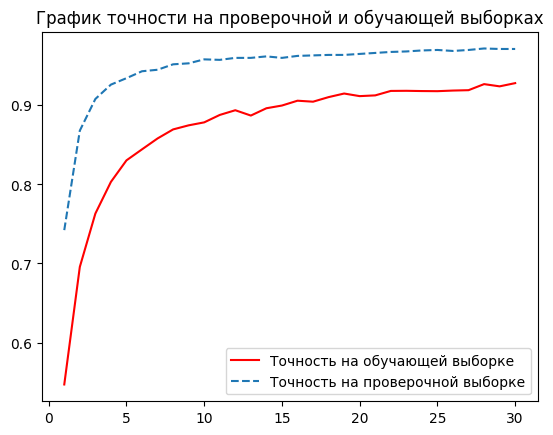

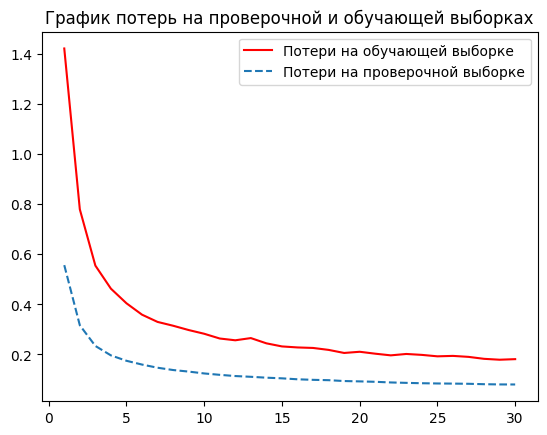

In [15]:
show_history(history)

#Результат на тестовой выборке

In [18]:
# сгенерируем данные из контрольного набор
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical',
    shuffle=False,
)
# оценим модель на контрольком наборе
test_loss, test_acc = model.evaluate(test_generator,
                                     steps=len(test_generator), # используем весь набор
                                     verbose=1
                                     )
print(f'Точность на контрольной выборке: {test_acc*100:.2f}%')

Found 2022 images belonging to 2 classes.
  1/102 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - acc: 0.8000 - loss: 0.4553

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - acc: 0.9431 - loss: 0.1235
Точность на контрольной выборке: 96.14%


#Итог
Мы построили Модель НС с использованием MobileNet — семейства сверточных нейронных сетей (CNN), разработанных Google для эффективного выполнения задач компьютерного зрения на мобильных устройствах и embedded-системах, основная цель которых - достичь высокой точности при минимальных вычислительных затратах. Добавили в нее свои плотные слои для обучения поиска категорий "Собаки" и "Кошки" и успешно обучили ее на 6000 изображениях с использованием генераторов, которые помогают изменять картинки, сохраняя их информационную ценность для модели.

Наша модель показала отличные результаты на валидационных данных - 97%, плавное схождение при обучении без резких выбросов и отклонений и отсутствие переобучения. Шаг обучения в 1е-5 довольно удобный параметр для плавного обучения.

На тестовых данных модель согла классифицировать изображения с точностью 96.14%, что требовалось для выполнения требований задания.

